1.) Load NASDAQ API key (Data Link API)


In [22]:
from dotenv import load_dotenv
import os

# Load the environment variables from .env file
load_dotenv("api_keys")

True

In [23]:
nasdaq_api_key = os.getenv('NASDAQ_API_KEY')
if len(nasdaq_api_key) > 0:
    print("loaded key")

loaded key


2.) Retrieve 1 year of COT data (% shifts producers long / short)

In [16]:
import requests
import pandas as pd
from datetime import datetime

# API endpoint components
base_url = "https://data.nasdaq.com/api/v3/datasets/"
dataset = "CFTC/084691_F_ALL"
data_format = ".json"

# Parameters
params = {
    "start_date": "2023-08-01",
    "end_date": "2024-08-01",
    "api_key": nasdaq_api_key  
}

# Construct the full URL
url = f"{base_url}{dataset}{data_format}"

# Make the API request
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    
    # Extract the dataset from the response
    dataset = data['dataset']
    
    # Create a pandas DataFrame
    df = pd.DataFrame(dataset['data'], columns=dataset['column_names'])
    
    # Convert the date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Set the date as the index
    df.set_index('Date', inplace=True)
    
    # Sort the DataFrame by date
    df.sort_index(inplace=True)
    
    # Display the first few rows of the DataFrame
    print(df.tail())
    
    # You can now use this DataFrame for further analysis or visualization
    
else:
    print(f"Error fetching data: {response.status_code}")
    print(response.text)

            Open Interest  Producer/Merchant/Processor/User Longs  \
Date                                                                
2023-12-05       139753.0                                  4714.0   
2023-12-12       134281.0                                  4311.0   
2023-12-19       127549.0                                  3701.0   
2023-12-26       131408.0                                  4063.0   
2024-01-02       134725.0                                  4483.0   

            Producer/Merchant/Processor/User Shorts  Swap Dealer Longs  \
Date                                                                     
2023-12-05                                  41340.0            33328.0   
2023-12-12                                  38849.0            30707.0   
2023-12-19                                  39714.0            30908.0   
2023-12-26                                  41011.0            29911.0   
2024-01-02                                  42194.0            30612.0  

In [3]:
df.columns

Index(['Open Interest', 'Producer/Merchant/Processor/User Longs',
       'Producer/Merchant/Processor/User Shorts', 'Swap Dealer Longs',
       'Swap Dealer Shorts', 'Swap Dealer Spreads', 'Money Manager Longs',
       'Money Manager Shorts', 'Money Manager Spreads',
       'Other Reportable Longs', 'Other Reportable Shorts',
       'Other Reportable Spreads', 'Total Reportable Longs',
       'Total Reportable Shorts', 'Non Reportable Longs',
       'Non Reportable Shorts'],
      dtype='object')

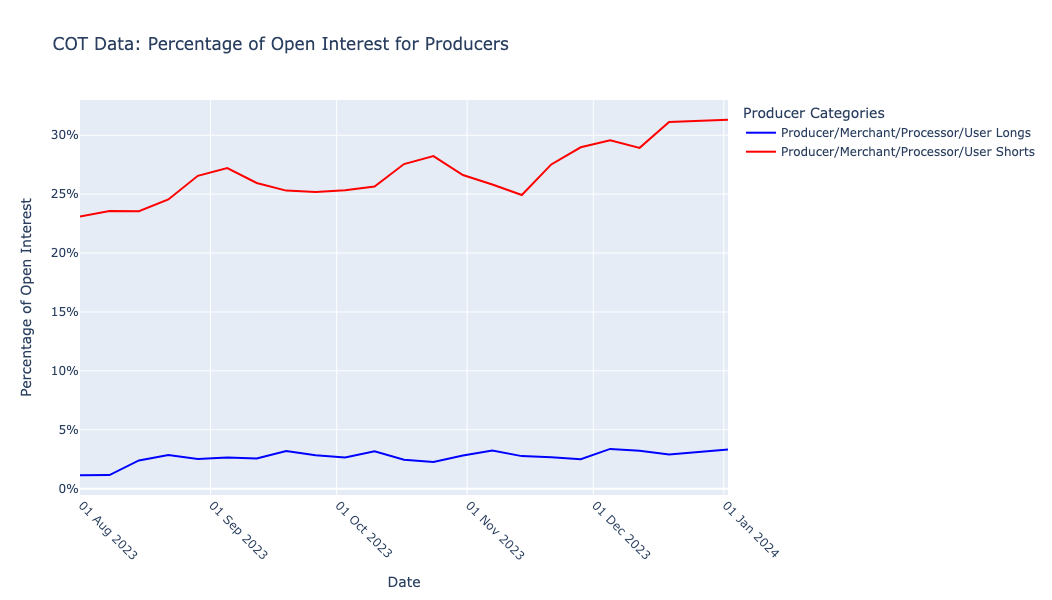


Metrics for Producer/Merchant/Processor/User Longs:
Volatility (Standard Deviation): 0.58%
Average: 2.68%
Median: 2.76%
Minimum: 1.14%
Maximum: 3.37%
Typical Range: 2.50% to 3.13%

Metrics for Producer/Merchant/Processor/User Shorts:
Volatility (Standard Deviation): 2.45%
Average: 26.86%
Median: 26.56%
Minimum: 23.11%
Maximum: 31.32%
Typical Range: 25.24% to 28.58%

Correlation between Longs and Shorts: 0.53


In [19]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Assuming df is your DataFrame with the COT data
# If not, you'll need to load your data here

# Calculate percentages for producers
categories = [
    'Producer/Merchant/Processor/User Longs',
    'Producer/Merchant/Processor/User Shorts'
]

for category in categories:
    df[f'{category} %'] = df[category] / df['Open Interest'] * 100

# Create the main figure
fig = go.Figure()

# Add traces for each category
colors = ['blue', 'red']
for i, category in enumerate(categories):
    fig.add_trace(go.Scatter(
        x=df.index, 
        y=df[f'{category} %'], 
        mode='lines',
        name=category,
        line=dict(width=2, color=colors[i])
    ))

# Update layout
fig.update_layout(
    title='COT Data: Percentage of Open Interest for Producers',
    yaxis_title='Percentage of Open Interest',
    xaxis_title='Date',
    legend_title='Producer Categories',
    height=600,
    width=1200,
    hovermode='x unified'
)

# Improve date labeling for better readability
fig.update_xaxes(
    tickformat="%d %b %Y",
    tickangle=45,
    dtick="M1",
    ticklabelmode="period"
)

# Set y-axis to percentage
fig.update_yaxes(ticksuffix='%')

# Show the plot
fig.show()

# Calculate and print metrics
for category in categories:
    print(f"\nMetrics for {category}:")
    data = df[f'{category} %']
    
    print(f"Volatility (Standard Deviation): {data.std():.2f}%")
    print(f"Average: {data.mean():.2f}%")
    print(f"Median: {data.median():.2f}%")
    print(f"Minimum: {data.min():.2f}%")
    print(f"Maximum: {data.max():.2f}%")
    
    # Calculate typical range
    typical_low = np.percentile(data, 25)
    typical_high = np.percentile(data, 75)
    print(f"Typical Range: {typical_low:.2f}% to {typical_high:.2f}%")

# Calculate and print the correlation between longs and shorts
correlation = df[f'{categories[0]} %'].corr(df[f'{categories[1]} %'])
print(f"\nCorrelation between Longs and Shorts: {correlation:.2f}")